# 分析手法について
この分析は，自分と相手を象徴する単語を用いて，単語の意味を点として表して，それを結んだ図形を作って，重なり具合を見る分析です．

必要なのは，自分と相手を象徴する単語と，その強さだけ．

# 使い方
1. このノートブックを開いたら，まずは上の方の
ランタイム>ランタイムのタイプを変更>(適当なGPU)
を選択してください．
1. このセルの1つ下のセルに
`my_word`には自分を意味する単語を，`my_word_strength`には書いた単語と同じ数だけの強さを書いてください．
相手の方も同様に，`others_word`と`others_word_stlength`にも書いてください．

  Note: `word`には`-`を使う事が可能です．例えば，`-幼稚性`と書けば，`幼稚性`の逆の意味を用いることが出来ます．
1. ランタイム>すべてのセルを実行
で，分析結果の図が出ます．

In [166]:
my_word = ['本能','幼稚性','-幼稚性','探究心']
my_word_strength = [9,10,5,9]
others_word = ['本能','対等愛','母性愛','役職']
others_word_strength = [8,9,9,6]

In [162]:
!pip install matplotlib_fontja
!pip install fugashi
!pip install unidic-lite
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
from shapely.geometry import Polygon as plgn
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib_fontja

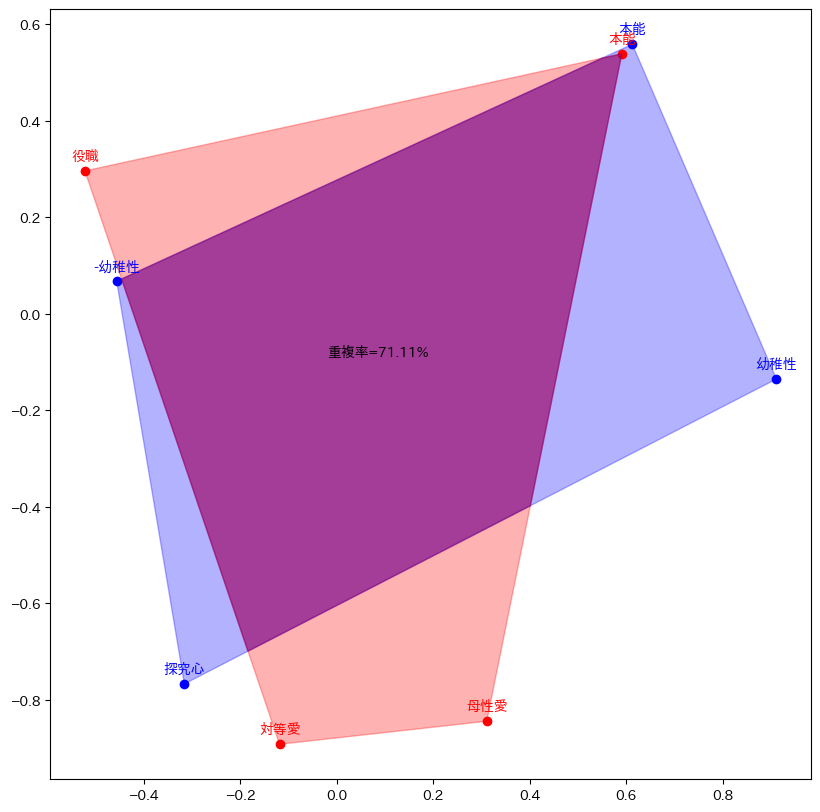

In [170]:
words = list(set([word.replace('-','') for word in my_word+others_word]))

model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda")
model = model.to(device)

def BERT_vectorize_word(word):
    inputs = tokenizer(word, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

vectors = np.array([BERT_vectorize_word(word) for word in words])
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)
vectors_2d = vectors_2d/ (np.linalg.norm(vectors_2d,axis=1).reshape(vectors_2d.shape[0],1) @ np.ones((1,2)))

my_vector = np.vstack([vectors_2d[words.index(word.replace('-','')),:] if word[0]!='-' else -vectors_2d[words.index(word.replace('-','')),:] for word in my_word])
others_vector = np.vstack([vectors_2d[words.index(word.replace('-','')),:] if word[0]!='-' else -vectors_2d[words.index(word.replace('-','')),:] for word in others_word])
my_vector = np.diag(my_word_strength) @ my_vector
others_vector = np.diag(others_word_strength) @ others_vector

def reorder_by_angle(vector,words,strength):
  x = vector[:, 0]
  y = vector[:, 1]
  angles = np.arctan2(y, x)
  indices = np.argsort(angles)
  return vector[indices,:], [words[i] for i in indices], [strength[i] for i in indices]
my_vector, my_word, my_word_strength = reorder_by_angle(my_vector,my_word, my_word_strength)
others_vector, others_word, others_word_strength = reorder_by_angle(others_vector,others_word, others_word_strength)

def normalize_vector_by_area(vector):
  plg = plgn(vector)
  if plg.area == 0:
    return np.zeros_like(vector)
  else:
    return np.diag(np.repeat((1/plg.area)**(1/2),vector.shape[0])) @ vector
my_vector = normalize_vector_by_area(my_vector)
others_vector = normalize_vector_by_area(others_vector)

def plot(my_vector,others_vector,my_word,others_word,plot_vector_rho=False,prev_my_vector=0,prev_others_vector=0):
  my_plgn = plgn(my_vector).convex_hull
  others_plgn = plgn(others_vector).convex_hull
  cross_plgn = plgn.intersection(my_plgn,others_plgn)
  if cross_plgn.geom_type == 'Polygon':
    cross_plgns = [cross_plgn]
  else:
    cross_plgns = list(cross_plgn.geoms)
  cross_plgns = [cross_plgn for cross_plgn in cross_plgns if not cross_plgn.geom_type == 'Point' and not cross_plgn.is_empty]
  fig, ax = plt.subplots(figsize=(10, 10))
  for i,vector in enumerate([my_vector,others_vector]):
    if i==0:
      lab = 'Me'
      col = 'blue'
      words = my_word
    else:
      lab = 'Others'
      col = 'red'
      words = others_word
    for j in range(vector.shape[0]):
      ax.scatter(vector[j,0],vector[j,1],c=col)
      ax.annotate(words[j],(vector[j,0],vector[j,1]+0.03),ha='center',va='center',c=col)
    ax.fill(vector[:,0],vector[:,1],color=col,alpha=0.3)

  for cross_plgn in cross_plgns:
    cross_coords = list(cross_plgn.exterior.coords)
    cross_vector = np.array([[p[0] for p in cross_coords],[p[1] for p in cross_coords]]).T
    ax.fill(cross_vector[:,0],cross_vector[:,1],color='purple',alpha=0.5)
  overlap_rate = sum([cross_plgn.area for cross_plgn in cross_plgns])/plgn(my_vector).area
  if overlap_rate == 0:
    cross_x = (my_plgn.centroid.x+others_plgn.centroid.x)/2
    cross_y = (my_plgn.centroid.y+others_plgn.centroid.y)/2
  else:
    max_cross_plgn = sorted(cross_plgns,key=lambda x:x.area,reverse=True)[0]
    cross_x = max_cross_plgn.centroid.x
    cross_y = max_cross_plgn.centroid.y
  ax.annotate('重複率='+str(round(overlap_rate*100,2))+'%',(cross_x,cross_y),ha='center',va='center',c='black')
  if plot_vector_rho:
    low = -0.05
    ax.annotate('Me',(cross_x,cross_y+1*low),ha='center',va='center',c='black')
    ax.annotate('('+','.join(my_word)+')',(cross_x,cross_y+2*low),ha='center',va='center',c='black')
    ax.annotate('=',(cross_x,cross_y+3*low),ha='center',va='center',rotation=90,c='black')
    rho_me = np.linalg.norm(my_vector,axis=1)/np.linalg.norm(prev_my_vector,axis=1)
    ax.annotate('('+','.join([str(round(x*100,2))+'%' for x in rho_me])+')',(cross_x,cross_y+4*low),ha='center',va='center',c='black')
    ax.annotate('Others',(cross_x,cross_y+5*low),ha='center',va='center',c='black')
    ax.annotate('('+','.join(others_word)+')',(cross_x,cross_y+6*low),ha='center',va='center',c='black')
    ax.annotate('=',(cross_x,cross_y+7*low),ha='center',va='center',rotation=90,c='black')
    rho_others = np.linalg.norm(others_vector,axis=1)/np.linalg.norm(prev_others_vector,axis=1)
    ax.annotate('('+','.join([str(round(x*100,2))+'%' for x in rho_others])+')',(cross_x,cross_y+8*low),ha='center',va='center',c='black')
  ax.set_aspect('equal')
  plt.show()

plot(my_vector,others_vector,my_word,others_word,plot_vector_rho=False)


# 反実仮想シミュレーション
互いの象徴する特性の強さが操作可能であると仮定します．重なり具合を最大にするように特性の強さを変化させた時，それぞれの特性はどのように弱化・強化するかを計算します．

1つ目の図は自分の特性の強さを変化させた時，2つ目の図は相手の特性の強さを変化させた時を表します．
例えば，前者は自分に対する相手の行動原理とか，後者は相手に対する自分の行動原理とかがわかるかもしれません．

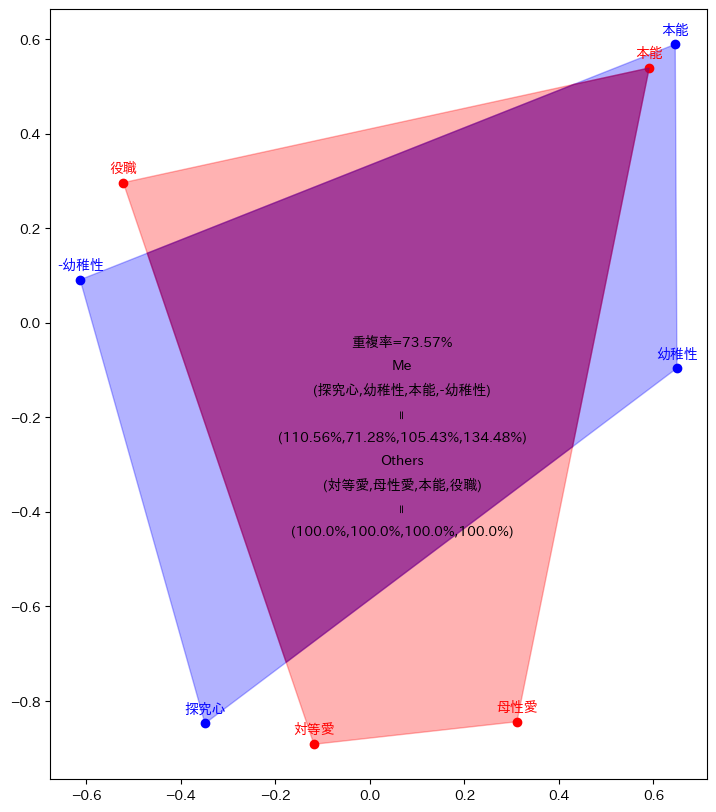

In [171]:
def objective(x,change_vector, steady_vector):
  change_vector = np.diag(x) @ change_vector
  change_vector = normalize_vector_by_area(change_vector)
  change_plgn = plgn(change_vector)
  steady_plgn = plgn(steady_vector)
  try:
    cross_plgn = plgn.intersection(change_plgn,steady_plgn)
    return -cross_plgn.area/steady_plgn.area
  except:
    return 0
opt = optimize.minimize(objective,x0=np.ones(my_vector.shape[0]),bounds=[(0,1) for i in range(my_vector.shape[0])],args=(my_vector,others_vector))

change_my_vector = np.diag(opt.x) @ my_vector
change_my_vector = normalize_vector_by_area(change_my_vector)
plot(change_my_vector,others_vector,my_word,others_word,plot_vector_rho=True,prev_my_vector=my_vector,prev_others_vector=others_vector)

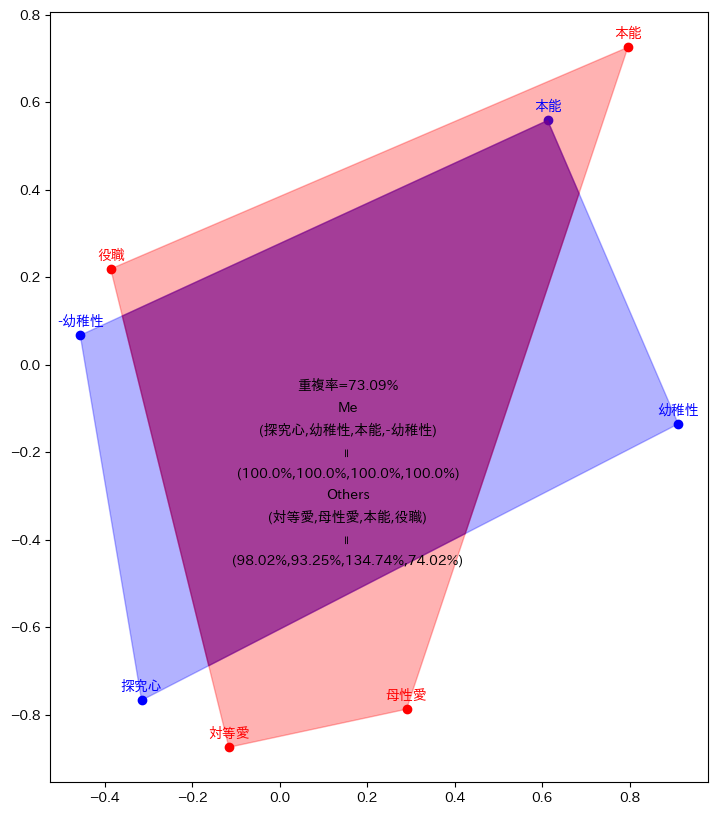

In [172]:
opt = optimize.minimize(objective,x0=np.ones(others_vector.shape[0]),bounds=[(0,1) for i in range(others_vector.shape[0])],args=(others_vector,my_vector))

change_others_vector = np.diag(opt.x) @ others_vector
change_others_vector = normalize_vector_by_area(change_others_vector)
plot(my_vector,change_others_vector,my_word,others_word,plot_vector_rho=True,prev_my_vector=my_vector,prev_others_vector=others_vector)